## Week 13 Lecture 1

Remember that we want to adjust the number of features to balance the accuracy and consistency of models. 

- Too many features could mean overfitting  
 * high accuracy in-sample 
 * low consisteny out-of-sample
- Too few features could mean underfitting 
 * low accuracy in-sample 
 * high consistency out-of-sample 

We could use backward feature selection to determine helpful features for predictions. However we should avoid any approach that involves fitting many models. Instead we can try regularization. Remember that for each feature we have a parameter in the model. For the prediction we multiply the feature and the parameter. If the parameter is 0 then the feature does not contribute to the model. So we should think of regularization like backward feature selection where we shrink parameters instead of eliminating features. 

We want to learn about two approaches to regularization called lasso and ridge. We will study the dataset on fuel efficiency. 

In [397]:
# import packages 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from scipy.optimize import minimize

# change settings

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 8)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)

# import for configuration

from IPython.display import Image

We will study a dataset on the fuel of efficiency of cars. Note the mpg is an acronym for miles per gallon. If the mpg is high, then the car has good fuel efficiency.

In [5]:
cars = sns.load_dataset('mpg').dropna()
cars

,mpg,cylinders,displacement,horsepower,...,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,...,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,...,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,...,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,...,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,...,10.5,70,usa,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,...,15.6,82,usa,ford mustang gl
394,44.0,4,97.0,52.0,...,24.6,82,europe,vw pickup
395,32.0,4,135.0,84.0,...,11.6,82,usa,dodge rampage
396,28.0,4,120.0,79.0,...,18.6,82,usa,ford ranger


Note that we have 392 records with 9 features. We take `mpg` for the response variable 

- `cylinders`
- `displacement`
- `horsepower`
- `weight`
- `acceleration`
- `model_year`
- `origin`
- `name`

for the explanatory variables. Note that `origin`, `model_year`, and `name` are qualitative variables. 

### Example (Lasso) 

Remember that we have been trying to predict `mpg` from `displacement`, `acceleration`, `horsepower` and `cylinders`.

In [342]:
cars_sample = pd.read_csv("cars_sample_2.csv")
cars_sample

,mpg,cylinders,displacement,horsepower,...,cylinders^2,displacement^2,horsepower^2,acceleration^2
0,18.0,8,307.0,130.0,...,64,94249.0,16900.0,144.00
1,15.0,8,350.0,165.0,...,64,122500.0,27225.0,132.25
2,18.0,8,318.0,150.0,...,64,101124.0,22500.0,121.00
3,16.0,8,304.0,150.0,...,64,92416.0,22500.0,144.00
4,17.0,8,302.0,140.0,...,64,91204.0,19600.0,110.25
...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86.0,...,16,19600.0,7396.0,243.36
388,44.0,4,97.0,52.0,...,16,9409.0,2704.0,605.16
389,32.0,4,135.0,84.0,...,16,18225.0,7056.0,134.56
390,28.0,4,120.0,79.0,...,16,14400.0,6241.0,345.96


We have add four more features to the table containing polynomial transformation of `displacement`, `acceleration`, `horsepower` and `cylinders`

In [343]:
def transform_to_standard_unit(array):
    return (array - np.mean(array)) / np.std(array) 

Remember that we transform to standard units by subtracting the mean and dividing by the standard deviation.

In [344]:
cars_sample = cars_sample.apply(transform_to_standard_unit)

We can split into 80% training set and 20% testing set.

In [345]:
def train_test_split(data, fraction, seed = 47):
    number_of_rows = len(data)

    data_shuffled = data.sample(n= number_of_rows, replace = False, random_state = seed)
    
    training_set = data_shuffled[:int(fraction * number_of_rows)]
    testing_set = data_shuffled[int(fraction * number_of_rows):]
    
    return training_set, testing_set

Remember that we need to split at random to avoid bias.

In [346]:
training_set, testing_set = train_test_split(cars_sample, 0.8)

Regularization means shrinking parameters to adjust the effective number of features in a model. We can shrink the parameters by modifying the average loss function. Remember that the mean square error for a linear model is 

$$L(a,b; x_1,\ldots,x_n,y_1,\ldots,y_n) = \frac{1}{n} \sum_{i=1}^n \; (a + b x_i - y_i)^2$$ 

We studied lasso regression to incorporate regularization into linear regression. Remember that we modified the function  
by adding another term

$$L(a,b; \lambda, x_1,\ldots,x_n,y_1,\ldots,y_n) = \lambda \left( |a| + |b| \right) + \frac{1}{n} \sum_{i=1}^n \; (a + b x_i - y_i)^2   $$ 

Here $\lambda$ is a positive number. We want to choose intercept $a$ and slope $b$ to minimize the function. So we need to make the differences between observations and predictions small along with the slope and intercept. The term 

$$ \lambda \left( |a| + |b| \right) $$

is small for $a$ and $b$ close to zero.

In [347]:
lasso_models = dict()
extra_parameters = np.logspace(-3,1,15)

for extra_parameter in extra_parameters:
    lasso_model = Lasso(alpha = extra_parameter, fit_intercept=False, max_iter=10000)
    lasso_model.fit(training_set.drop(columns = "mpg"), training_set["mpg"])
    
    lasso_models[extra_parameter] = lasso_model

For each value of the extra parameter we can fit a model. If we increase the value of the extra parameter then the slopes shrink to zero. If we decrease the value of the extra parameter then the slopes approach the values for the slopes in linear regression.

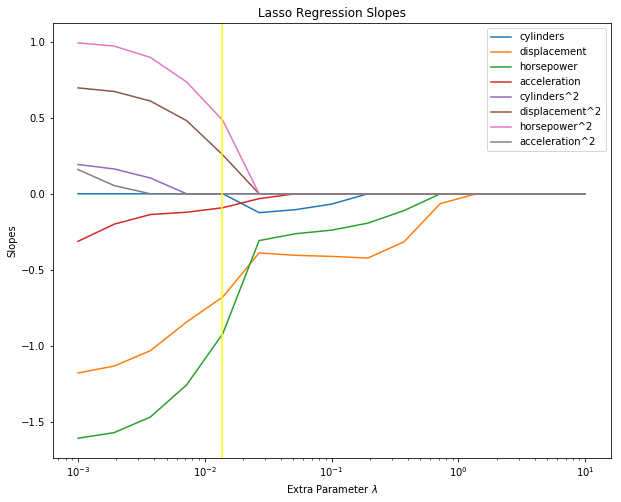

In [348]:
labels = ['cylinders', 'displacement', 'horsepower', 'acceleration', 'cylinders^2', 'displacement^2', 'horsepower^2', 'acceleration^2']

coefs = []
for extra_parameter in extra_parameters:
    model = lasso_models[extra_parameter]
    coefs.append(model.coef_)

coefs = zip(*coefs)
for coef, label in zip(coefs, labels):
    plt.semilogx(extra_parameters, coef, label = label)

plt.axvline(x = 0.0138, color = "yellow")
    
plt.xlabel('Extra Parameter $\lambda$')
plt.ylabel('Slopes')
plt.title('Lasso Regression Slopes')
plt.legend();

Which value for the extra parameter gives the best model in terms of accuracy and consistency? The line in yellow corresponds to the value 

$$\lambda = 0.014$$

Here the features are 

- `displacement`, `acceleration`, `horsepower`
- `displacement^2`, `horsepower^2`

Since the other three parameters are 0, the model does not use the features 

- `cylinders`
- `cylinders^2`, `acceleration^2` 

How can we arrive at this value for the extra parameter?

In [349]:
def compute_training_testing_errors(training_set, testing_set, model):
    predictions_training = model.predict(training_set.drop(columns = ["mpg"]))
    mse_training = np.mean((predictions_training - training_set["mpg"].values)**2)

    predictions_testing = model.predict(testing_set.drop(columns = ["mpg"]))
    mse_testing = np.mean((predictions_testing - testing_set["mpg"].values)**2)
    
    return mse_training, mse_testing

For a value of the extra parameter we can compute the mean square error on the training set and the testing set. Note that we omit the term $$\lambda \left(|a| + |b| \right) $$ Instead we calculate $$\frac{1}{n} \sum_{i = 1}^{n} \left(a + b x_i - y_i \right)^2$$ to assess the accuracy of the model in-sample and out-of-sample. For example, we can compute the training error and testing error on the lasso regression model with $\lambda = 0.001$. The lasso regression model should be similar to the linear regression model because the extra parameter is small.  

In [350]:
model = lasso_models[extra_parameters[0]]
mse_training_lasso, mse_testing_lasso = compute_training_testing_errors(training_set, testing_set, model)

print(f"Training Error {mse_training_lasso} and Testing Error {mse_testing_lasso} for Lasso Regression with Small Extra Parameter 0.001")

Training Error 0.23904464290944152 and Testing Error 0.2460537633285843 for Lasso Regression with Small Extra Parameter 0.001


In [351]:
model = LinearRegression(fit_intercept=False)
model.fit(training_set.drop(columns = ["mpg"]), training_set["mpg"])

mse_training_linear, mse_testing_linear = compute_training_testing_errors(training_set, testing_set, model)

print(f"Training Error {mse_training_lasso} and Testing Error {mse_testing_lasso} for Linear Regression")

Training Error 0.23904464290944152 and Testing Error 0.2460537633285843 for Linear Regression


We can use 2-fold cross validation to assess both the accuracy and consistency of the models for different values of the extra parameter.

In [352]:
training_subset_1, training_subset_2 = train_test_split(training_set, 0.5, seed = 35)

Remember that we split the training set into two tables. We use one table for training set and the other table for validation set.

In [353]:
validation_errors = []
for extra_parameter in extra_parameters:
    mse_training_1, mse_validating_1 = compute_training_testing_errors(training_subset_1, training_subset_2, lasso_models[extra_parameter])
    mse_training_2, mse_validating_2 = compute_training_testing_errors(training_subset_2, training_subset_1, lasso_models[extra_parameter])
    
    validation_errors.append([mse_validating_1, mse_validating_2])

We have two numbers for each model from 2-fold cross validation. We take the average of the numbers along with the standard deviation.

In [354]:
validation_errors = pd.DataFrame(data = validation_errors, index = extra_parameters)

means = validation_errors.apply(np.mean, axis = 1)
stds = validation_errors.apply(np.std, axis = 1)

validation_errors["average"] = means   
validation_errors["std"] = stds

validation_errors

,0,1,average,std
0.001000,0.224323,0.253860,0.239092,0.014768
0.001931,0.226656,0.253687,0.240172,0.013515
0.003728,0.230998,0.254990,0.242994,0.011996
0.007197,0.242558,0.260875,0.251716,0.009159
0.013895,0.269895,0.276078,0.272987,0.003091
...,...,...,...,...
0.719686,0.880448,0.873065,0.876756,0.003691
1.389495,0.973356,0.973995,0.973675,0.000319
2.682696,0.973356,0.973995,0.973675,0.000319
5.179475,0.973356,0.973995,0.973675,0.000319


Using error bars we can display the difference between the two folds measured by standard deviation.

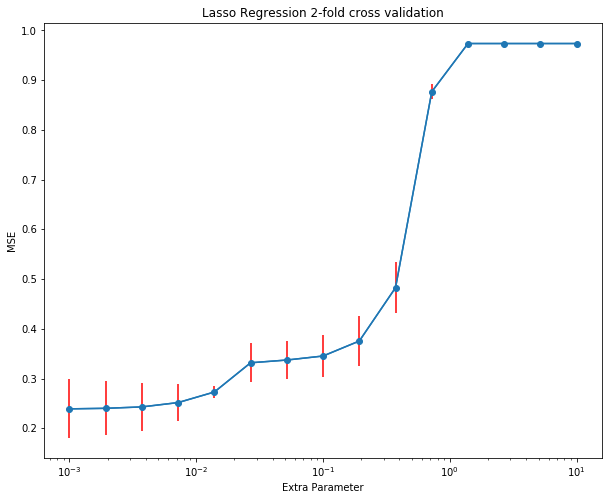

In [355]:
plt.semilogx(extra_parameters, validation_errors["average"])
plt.errorbar(extra_parameters, validation_errors["average"], yerr=4*validation_errors["std"], fmt='-o', ecolor = "r")
plt.title('Lasso Regression 2-fold cross validation')
plt.xlabel('Extra Parameter')
plt.ylabel('MSE');

So we learn that the different models have varying accuracy and consistency

- extra parameter between 0.001 and 0.01
  * high accuracy 
  * low consistency 
- extra parameter between 1 and 10
  * low accuracy 
  * high consistency 
  
The best value for the extra parameter is approximately 0.014. It has high accuracy and high consistency. So we expect the model to give good predictions across samples.

### Example (Ridge) 

For lasso regression we study the function

$$L(a,b; \lambda, x_1,\ldots,x_n,y_1,\ldots,y_n) = \lambda \left( |a| + |b| \right) + \frac{1}{n} \sum_{i=1}^n \; (a + b x_i - y_i)^2   $$ 

where $\lambda$ is a positive number. Instead of the term 

$$ \lambda \left( |a| + |b| \right) $$

we could use the term

$$ \lambda \left( a^2 + b^2 \right) $$

For ridge regression we choose intercept $a$ and slope $b$ to minimize the function

$$L(a,b; \lambda, x_1,\ldots,x_n,y_1,\ldots,y_n) = \lambda \left( a^2 + b^2 \right)  + \frac{1}{n} \sum_{i=1}^n \; (a + b x_i - y_i)^2   $$ 

Both terms will be small for $a$ and $b$ close to zero. However the slope and intercept for ridge regression and lasso regression can be different.


In [325]:
ridge_models = dict()
extra_parameters = np.logspace(-2,3,15)

for extra_parameter in extra_parameters:
    ridge_model = Ridge(alpha = extra_parameter, fit_intercept=False, max_iter=10000)
    ridge_model.fit(training_set.drop(columns = "mpg"), training_set["mpg"])
    
    ridge_models[extra_parameter] = ridge_model

For each value of the extra parameter we can fit a model. If we increase the value of the extra parameter then the we shrink the slopes. If we decrease the value of the extra parameter then the slopes approach the values for the slopes in linear regression. Note that the slopes for ridge regression are small but nonzero unlike lasso regression. So ridge regression does not eliminate features by shrinking parameters all the way to 0. 

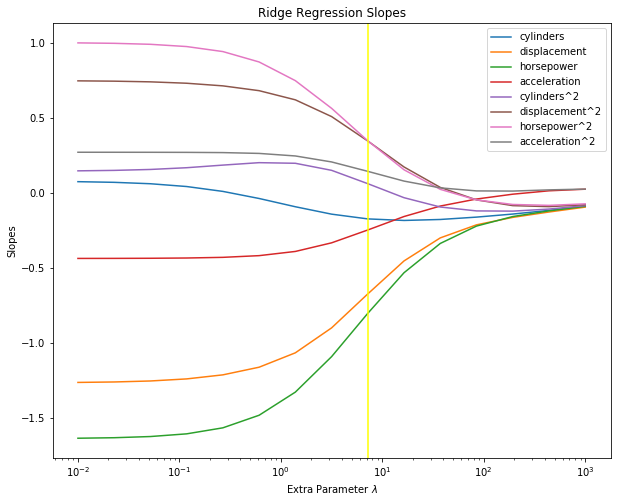

In [326]:
labels = ['cylinders', 'displacement', 'horsepower', 'acceleration', 'cylinders^2', 'displacement^2', 'horsepower^2', 'acceleration^2']

coefs = []
for extra_parameter in extra_parameters:
    model = ridge_models[extra_parameter]
    coefs.append(model.coef_)

coefs = zip(*coefs)
for coef, label in zip(coefs, labels):
    plt.semilogx(extra_parameters, coef, label = label)

plt.axvline(x = 7.19, color = "yellow")
    
plt.xlabel('Extra Parameter $\lambda$')
plt.ylabel('Slopes')
plt.title('Ridge Regression Slopes')
plt.legend();

Which value for the extra parameter gives the best model in terms of accuracy and consistency? The line in yellow corresponds to the value 

$$\lambda = 7.19$$

All eight features appear in the model. However 

- `displacement`, `acceleration`, `horsepower`
- `displacement^2`, `horsepower^2`

have slopes father from 0 and

- `cylinders`
- `cylinders^2`, `acceleration^2` 

have slopes closer to 0. Both ridge regression and lasso regression indicate the helpful features for prediction. However, ridge regression does not eliminate the unhelpful features.

How can we arrive at this value for the extra parameter?

In [327]:
def compute_training_testing_errors(training_set, testing_set, model):
    predictions_training = model.predict(training_set.drop(columns = ["mpg"]))
    mse_training = np.mean((predictions_training - training_set["mpg"].values)**2)

    predictions_testing = model.predict(testing_set.drop(columns = ["mpg"]))
    mse_testing = np.mean((predictions_testing - testing_set["mpg"].values)**2)
    
    return mse_training, mse_testing

We can use 2-fold cross validation to assess both the accuracy and consistency of the models for different values of the extra parameter.

In [328]:
training_subset_1, training_subset_2 = train_test_split(training_set, 0.5, seed = 1)

Remember that we split the training set into two tables. We use one table for training set and the other table for validation set.

In [329]:
validation_errors = []
for extra_parameter in extra_parameters:
    mse_training_1, mse_validating_1 = compute_training_testing_errors(training_subset_1, training_subset_2, ridge_models[extra_parameter])
    mse_training_2, mse_validating_2 = compute_training_testing_errors(training_subset_2, training_subset_1, ridge_models[extra_parameter])
    
    validation_errors.append([mse_validating_1, mse_validating_2])

We have two numbers for each model from 2-fold cross validation. We take the average of the numbers along with the standard deviation.

In [330]:
validation_errors = pd.DataFrame(data = validation_errors, index = extra_parameters)

means = validation_errors.apply(np.mean, axis = 1)
stds = validation_errors.apply(np.std, axis = 1)

validation_errors["average"] = means   
validation_errors["std"] = stds

validation_errors

,0,1,average,std
0.010000,0.227447,0.249895,0.238671,0.011224
0.022758,0.227468,0.249877,0.238673,0.011204
0.051795,0.227522,0.249838,0.238680,0.011158
0.117877,0.227670,0.249762,0.238716,0.011046
0.268270,0.228118,0.249659,0.238888,0.010770
...,...,...,...,...
37.275937,0.332660,0.322527,0.327594,0.005066
84.834290,0.352856,0.340932,0.346894,0.005962
193.069773,0.367560,0.358897,0.363228,0.004331
439.397056,0.389576,0.388393,0.388985,0.000591


Using error bars we can display the difference between the two folds measured by standard deviation.

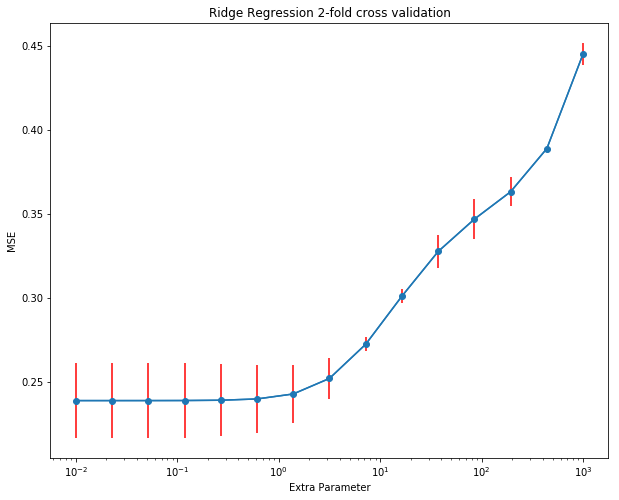

In [331]:
plt.semilogx(extra_parameters, validation_errors["average"])
plt.errorbar(extra_parameters, validation_errors["average"], yerr=2*validation_errors["std"], fmt='-o', ecolor = "r")
plt.title('Ridge Regression 2-fold cross validation')
plt.xlabel('Extra Parameter')
plt.ylabel('MSE');

So we learn that the different models have varying accuracy and consistency

- extra parameter between 0.01 and 1
  * high accuracy 
  * low consistency 
- extra parameter between 100 and 1000
  * low accuracy 
  * high consistency 
  
The best value for the extra parameter is approximately 7.19. It has high accuracy and high consistency. So we expect the model to give good predictions across samples.

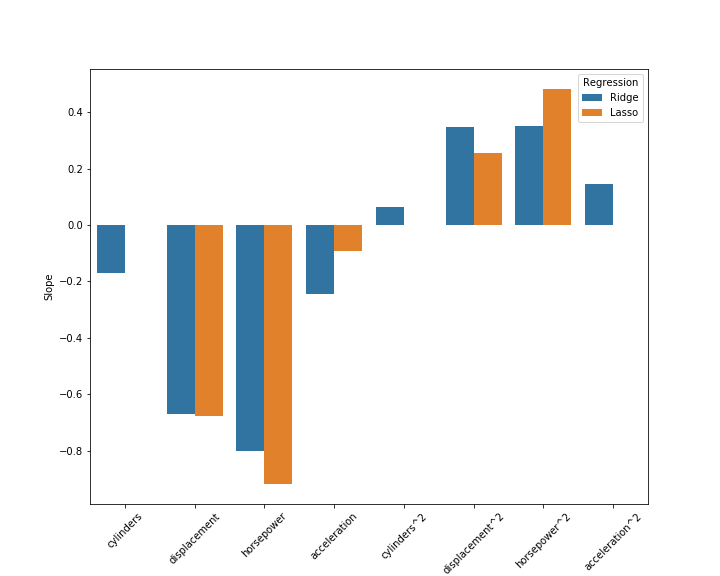

In [398]:
Image("slopes.png")

### Exercise (Shrinking Parameters) 

Remember that the mean square error for a linear model is 

$$L(a,b; x_1,\ldots,x_n,y_1,\ldots,y_n) = \frac{1}{n} \sum_{i=1}^n \; (a + b x_i - y_i)^2$$ 

Here we would choose $a,b$ to minimize the function. Take $\lambda$ to be positive number. Suppose we add another term  

$$L(a,b; \lambda, x_1,\ldots,x_n,y_1,\ldots,y_n) = \lambda \cdot b + \frac{1}{n} \sum_{i=1}^n \; (a + b x_i - y_i)^2   $$ 

Again we want to choose $a,b$ to minimize the function. However, here we must make the differences between observations and predictions small along with the slope. The term 

$$ \lambda \cdot b $$

is small for $b$ close to zero or negative. Why would we want a model that tries to make the slope zero or negative? 

In [332]:
y = cars["mpg"]

X = pd.DataFrame(data = {
  "intercept": 1,
  "acceleration": cars["acceleration"] })

Consider the features `acceleration` and `mpg` from the `cars` table. Note that we have a positive trend between `acceleration` and `mpg`.

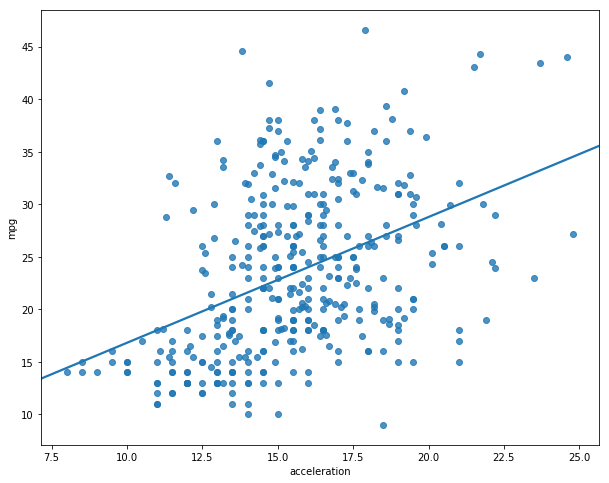

In [333]:
sns.regplot(x = "acceleration", y = "mpg", data = cars, ci = 0);

However, we might have knowledge about the impact of acceleration speeds on the fuel efficiency of cars. Suppose we know that cars with high acceleration speeds should have lower miles-per-gallon. The data in the sample would not be representative of the population. Nonetheless we can learn from the data in the sample with a model that incorporate our knowledge about the trend between `acceleration` and `mpg`.

In [334]:
extra_parameter = 0 

def function_for_minimization(w):
    return np.mean((y - np.dot(X, w))**2) + extra_parameter * w[1]

intercept_0, slope_0 = minimize(function_for_minimization, x0 = np.random.rand(2)).x

print(f"Slope {slope_0} and Intercept {intercept_0}")

Slope 1.1976241459160013 and Intercept 4.833250612887392


Note that for the extra parameter $\lambda$ equal to 0, the slope is 1.19. If we increase the value of the extra parameter $\lambda$ to 50, then the model puts more emphasis on the size of the slope. 

In [335]:
extra_parameter = 50 

def function_for_minimization(w):
    return np.mean((y - np.dot(X, w))**2) + extra_parameter * w[1]

intercept_50, slope_50 = minimize(function_for_minimization, x0 = np.random.rand(2)).x

print(f"Slope {slope_50} and Intercept {intercept_50}")

Slope -2.0953526366603485 and Intercept 56.01047762969436


Now the slope is -2.09. We can try out the two slopes on a different sample of data. 

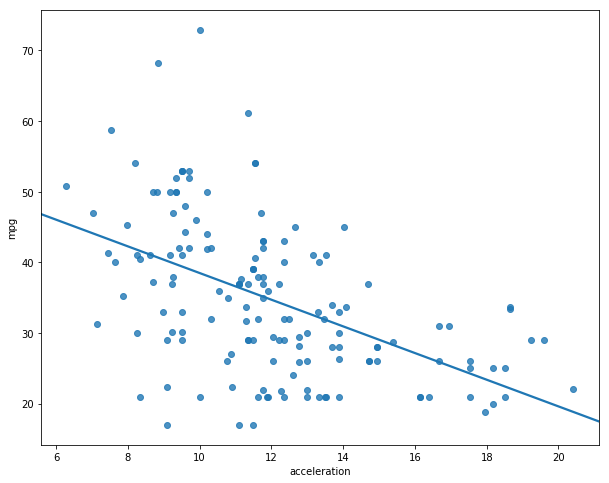

In [336]:
cars_sample = pd.read_csv("cars_sample_1.csv")
cars_sample = cars_sample[["acceleration", "mpg"]]

sns.regplot(x = "acceleration", y = "mpg", data = cars_sample, ci = 0);

Note that the data in the sample has the expected negative trend. We can plot the predictions corresponding to slopes for extra parameters $\lambda = 0$ and extra parameter $\lambda = 50$.

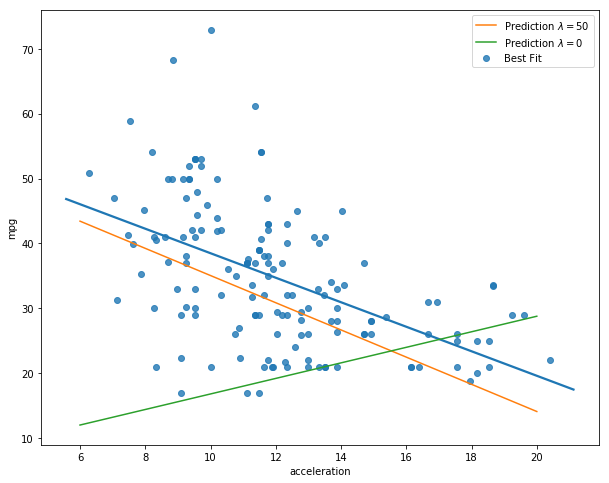

In [337]:
sns.regplot(x = "acceleration", y = "mpg", data = cars_sample, ci = 0, label ="Best Fit")

xvalues = np.linspace(6,20,100)
plt.plot(xvalues, intercept_50 + slope_50 * xvalues, label = "Prediction $\lambda = 50$")
plt.plot(xvalues, intercept_0 + slope_0 * xvalues, label = "Prediction $\lambda = 0$")

plt.legend();

Based on knowledge about the population of cars, we trained a model that shrinks slope on a sample with a positive trend between `acceleration` and `mpg`. By shrinking the slope, we obtained more accurate estimates on a sample with a negative trend between `acceleration` and `mpg`. So shrinking weights can help us to use our understanding of a population to learn from unrepresentative samples. 